# 🇺🇸 USA Names Analysis with BigQuery

This notebook explores the [USA Baby Names dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=usa_names&page=dataset) from Google BigQuery using a combination of **SQL queries** and **Python-based analysis**.

The goal is to investigate naming trends in the United States from 1910 to 2013, and demonstrate how SQL and Python can work together for exploratory data analysis and predictive modeling.

---

### 🔍 Topics Covered

1. Top 10 names per year (by gender)  

2. Emerging names

3. Name persistence  

4. Popularity forecasting  

5. Trend clustering  
---

This notebook is ideal for practicing advanced SQL on time-series-like data, combining it with Python libraries for data visualization, clustering, and forecasting.


In [1]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "stackoverflow" dataset
dataset_ref = client.dataset("usa_names", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.


In [2]:
# Get a list of available tables 

tables =  list(client.list_tables(dataset)) 
list_of_tables = [table.table_id for table in tables]

print(list_of_tables)

['usa_1910_2013', 'usa_1910_current']


In [3]:
# Construct a reference to the "usa_1910_2013" table
names_2013_ref = dataset_ref.table("usa_1910_2013")

# API request - fetch the table
names_2013_table = client.get_table(names_2013_ref)

# Preview the first five lines of the "posts_answers" table
client.list_rows(names_2013_table, max_results=5).to_dataframe()

,state,gender,year,name,number
0,AL,F,1910,Sadie,40
1,AL,F,1910,Mary,875
2,AR,F,1910,Vera,39
3,AR,F,1910,Marie,78
4,AR,F,1910,Lucille,66


In [4]:
names_current_ref = dataset_ref.table("usa_1910_current")

names_current_table = client.get_table(names_current_ref)

client.list_rows(names_current_table, max_results=5).to_dataframe()

,state,gender,year,name,number
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


### 1) Top 10 names 

In [5]:
top5_query = """ 
                      WITH names_agg AS (
      SELECT
        year,
        gender,
        name,
        SUM(number) AS total
      FROM `bigquery-public-data.usa_names.usa_1910_current`
      WHERE year BETWEEN 2015 AND 2020
      GROUP BY year, gender, name
    )
    
    SELECT
      year,
      gender,
      name,
      total,
      RANK() OVER (PARTITION BY year, gender ORDER BY total DESC) AS rank
    FROM names_agg
    QUALIFY rank <= 5
    ORDER BY year, gender, rank;

                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
top5_job = client.query(top5_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
top5_results = top5_job.to_dataframe() # Your code goes here

# Preview results
print(top5_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


    year gender       name  total  rank
0   2015      F       Emma  20468     1
1   2015      F     Olivia  19713     2
2   2015      F     Sophia  17437     3
3   2015      F        Ava  16391     4
4   2015      F   Isabella  15641     5
5   2015      M       Noah  19654     1
6   2015      M       Liam  18397     2
7   2015      M      Mason  16649     3
8   2015      M      Jacob  15973     4
9   2015      M    William  15928     5
10  2016      F       Emma  19531     1
11  2016      F     Olivia  19386     2
12  2016      F        Ava  16329     3
13  2016      F     Sophia  16159     4
14  2016      F   Isabella  14837     5
15  2016      M       Noah  19164     1
16  2016      M       Liam  18242     2
17  2016      M    William  15790     3
18  2016      M      Mason  15271     4
19  2016      M      James  14892     5
20  2017      F       Emma  19847     1
21  2017      F     Olivia  18753     2
22  2017      F        Ava  15998     3
23  2017      F   Isabella  15222     4


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


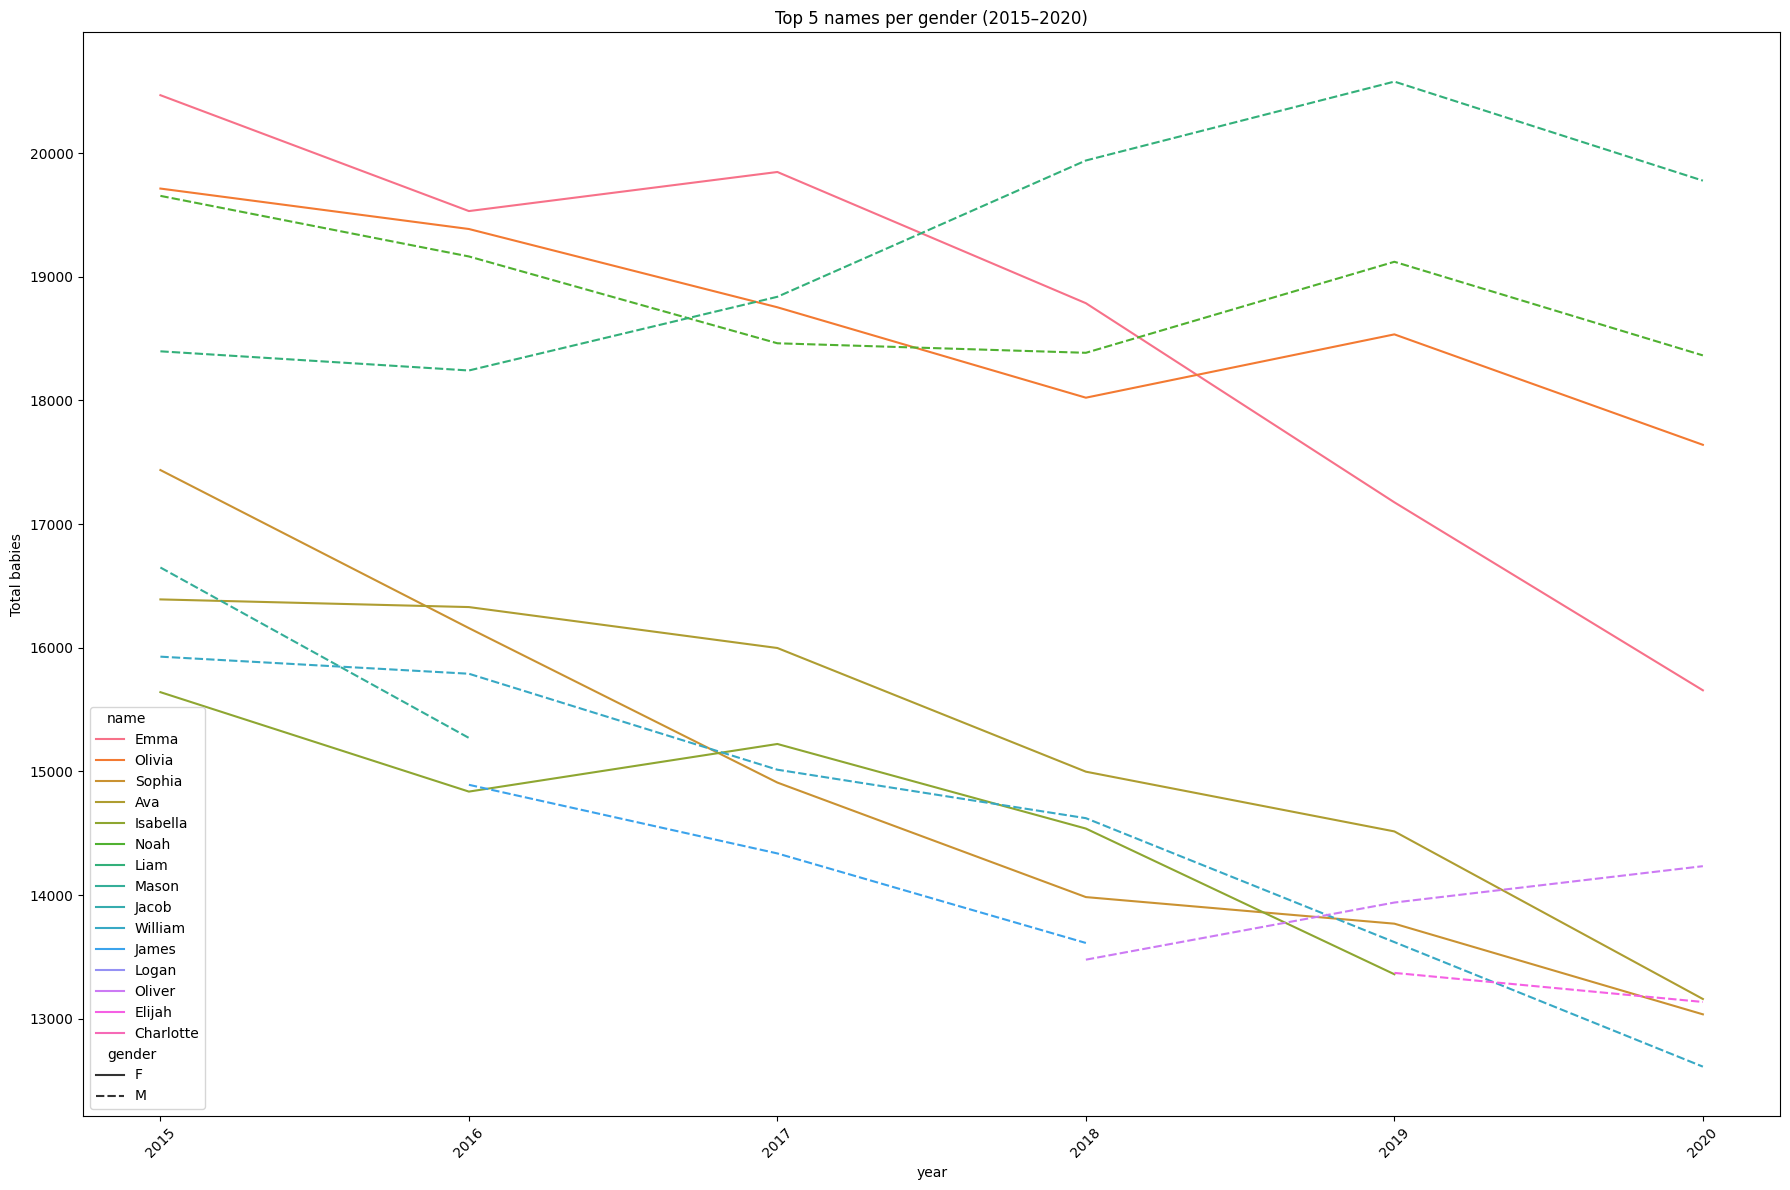

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df = risultato della query precedente
plt.figure(figsize=(18, 12))
sns.lineplot(data=top5_results, x="year", y="total", hue="name", style="gender")
plt.title("Top 5 names per gender (2015–2020)")
plt.ylabel("Total babies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2) Nomi innovativi: quelli che emergono rapidamente

In [7]:
innovativenames_query = """ 
                      WITH names_yearly AS (
                      SELECT
                      year,
                      name,
                      SUM(number) AS count
                      FROM `bigquery-public-data.usa_names.usa_1910_current`
                       WHERE year IS NOT NULL
                      GROUP BY year, name), 

                      growth AS (
                      SELECT
                      year, 
                      name,
                      count,
                      LAG(count) OVER (PARTITION BY name ORDER BY year) AS prev_year_count

                      FROM names_yearly
                      WHERE count IS NOT NULL
                      ),
                        pct AS (
                          SELECT
                            name,
                            year,
                            count,
                            prev_year_count,
                            ROUND(100 * (count - prev_year_count) / prev_year_count, 2) AS pct_growth
                          FROM growth
                          WHERE prev_year_count IS NOT NULL
                        )
                        SELECT *
                        FROM pct
                        WHERE pct_growth > 50 AND count >= 20
                        ORDER BY pct_growth DESC
                        LIMIT 10;
                     """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
innovativenames_job = client.query(innovativenames_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
innovativenames_results = innovativenames_job.to_dataframe() # Your code goes here

# Preview results
print(innovativenames_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


       name  year  count  prev_year_count  pct_growth
0    Deneen  1964   1572                5    31340.00
1   Aaliyah  1994   1412                5    28140.00
2   Mallory  1983    658                5    13060.00
3    Tenley  2010    650                5    12900.00
4    Tammie  1957    584                5    11580.00
5     Jalen  1992    583                6     9616.67
6       Aja  1978    436                5     8620.00
7  Cataleya  2012    618                8     7625.00
8  Jeannine  1928    377                5     7440.00
9   Krystle  1981    415                6     6816.67


In [8]:
# Se potrebbero esserci NaN o pd.NA
innovativenames_results["count"] = pd.to_numeric(innovativenames_results["count"], errors="coerce")
innovativenames_results["pct_growth"] = pd.to_numeric(innovativenames_results["pct_growth"], errors="coerce")


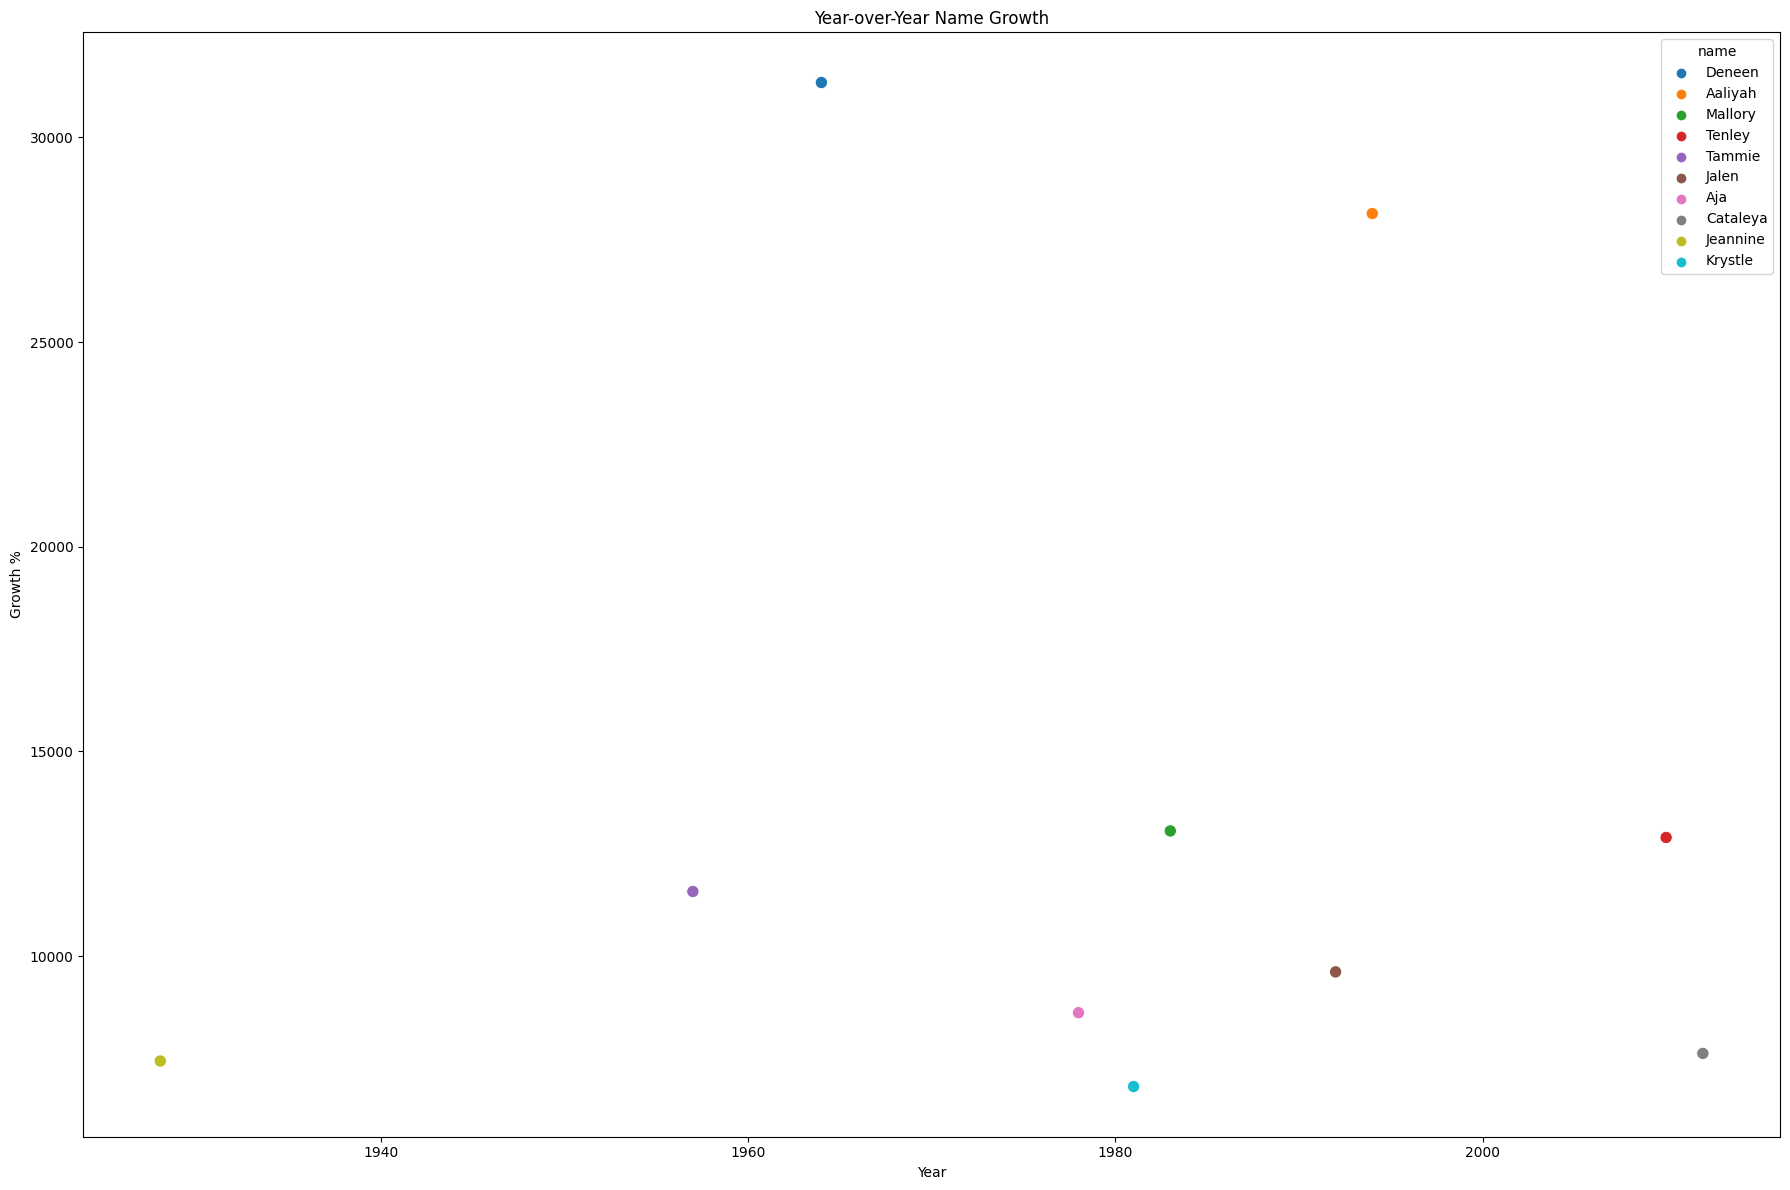

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))
sns.scatterplot(data=innovativenames_results, x="year", y="pct_growth", hue="name", s=80)
plt.title("Year-over-Year Name Growth")
plt.xlabel("Year")
plt.ylabel("Growth %")
plt.tight_layout()
plt.show()


### 3) Nomi più persistenti nei top 10 

In [10]:
persistent10_query = """ 
                      WITH ranked AS (
                      SELECT
                      year,
                      name,
                      number, 
                      gender,
                      RANK() OVER (PARTITION BY year, gender ORDER BY number DESC) AS rank
                      FROM `bigquery-public-data.usa_names.usa_1910_current`
                      ),
                      top10_names AS (
                      SELECT *
                      FROM ranked
                      WHERE rank <= 10
                      )
                      SELECT
                      name,
                      gender,
                        COUNT(DISTINCT year) AS years_in_top10
                        FROM top10_names
                        GROUP BY name, gender
                        ORDER BY years_in_top10 DESC
                        LIMIT 20
                     """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
persistent10_job = client.query(persistent10_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
persistent10_results = persistent10_job.to_dataframe() # Your code goes here

# Preview results
print(persistent10_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


           name gender  years_in_top10
0        Robert      M              62
1          John      M              62
2         David      M              61
3          Mary      F              57
4       Michael      M              56
5         James      M              44
6        Daniel      M              40
7       William      M              40
8      Jennifer      F              35
9       Matthew      M              33
10  Christopher      M              33
11     Patricia      F              31
12      Jessica      F              27
13       Andrew      M              27
14       Ashley      F              26
15      Anthony      M              24
16       Joseph      M              23
17        Emily      F              23
18      Barbara      F              22
19      Richard      M              21


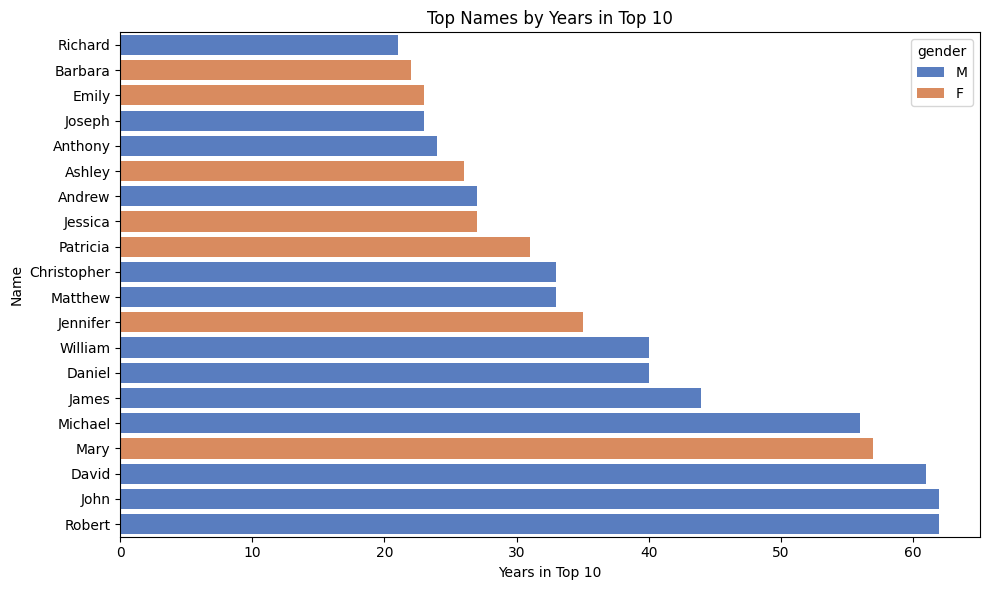

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

persistent10_results = persistent10_results.dropna(subset=["years_in_top10"])
persistent10_results["years_in_top10"] = persistent10_results["years_in_top10"].astype(int)

df_sorted = persistent10_results.sort_values("years_in_top10", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_sorted,
    x="years_in_top10",
    y="name",
    hue="gender",
    dodge=False,
    palette="muted"
)
plt.title("Top Names by Years in Top 10")
plt.xlabel("Years in Top 10")
plt.ylabel("Name")
plt.tight_layout()
plt.show()


### 4) Top 10 nomi per sesso nel periodo 2000–2013 vs 2014–2020

In [12]:
top10_compare_query = """ 
                      WITH top_pre AS (
                      SELECT name, gender, SUM(number) AS total
                      FROM `bigquery-public-data.usa_names.usa_1910_2013`
                      WHERE year BETWEEN 2000 AND 2013
                      GROUP BY name, gender
                      ORDER BY total DESC
                      LIMIT 10
                    ),
                    top_post AS (
                      SELECT name, gender, SUM(number) AS total
                      FROM `bigquery-public-data.usa_names.usa_1910_current`
                      WHERE year BETWEEN 2014 AND 2020
                      GROUP BY name, gender
                      ORDER BY total DESC
                      LIMIT 10
                    )
                    SELECT '2000‑2013' AS period, name, gender, total
                    FROM top_pre
                    UNION ALL
                    SELECT '2014‑2020' AS period, name, gender, total
                    FROM top_post
                    ORDER BY period, gender, total DESC;

                     """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
top10_compare_job = client.query(top10_compare_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
top10_compare_results = top10_compare_job.to_dataframe() # Your code goes here

# Preview results
print(top10_compare_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


       period      name gender   total
0   2000‑2013     Emily      F  278699
1   2000‑2013      Emma      F  258862
2   2000‑2013     Jacob      M  352950
3   2000‑2013   Michael      M  315767
4   2000‑2013    Joshua      M  285105
5   2000‑2013   Matthew      M  276740
6   2000‑2013     Ethan      M  270059
7   2000‑2013    Daniel      M  262916
8   2000‑2013   William      M  261804
9   2000‑2013    Andrew      M  253890
10  2014‑2020      Emma      F  132413
11  2014‑2020    Olivia      F  131875
12  2014‑2020    Sophia      F  107928
13  2014‑2020       Ava      F  107106
14  2014‑2020  Isabella      F  102871
15  2014‑2020      Liam      M  134244
16  2014‑2020      Noah      M  132474
17  2014‑2020   William      M  104423
18  2014‑2020     James      M   97639
19  2014‑2020     Mason      M   96729


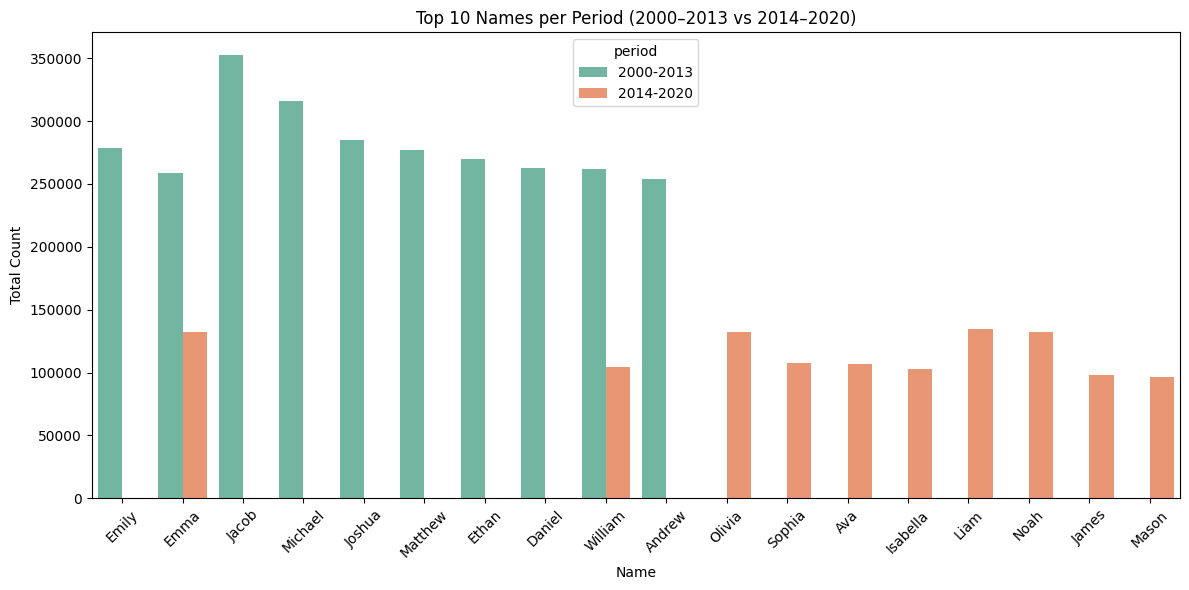

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

top10_compare_results = top10_compare_results.dropna(subset=["total"])
top10_compare_results["total"] = top10_compare_results["total"].astype(int)


# Assumendo che `df` sia il risultato della query
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10_compare_results,
    x="name",
    y="total",
    hue="period",
    palette="Set2"
)
plt.title("Top 10 Names per Period (2000–2013 vs 2014–2020)")
plt.ylabel("Total Count")
plt.xlabel("Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


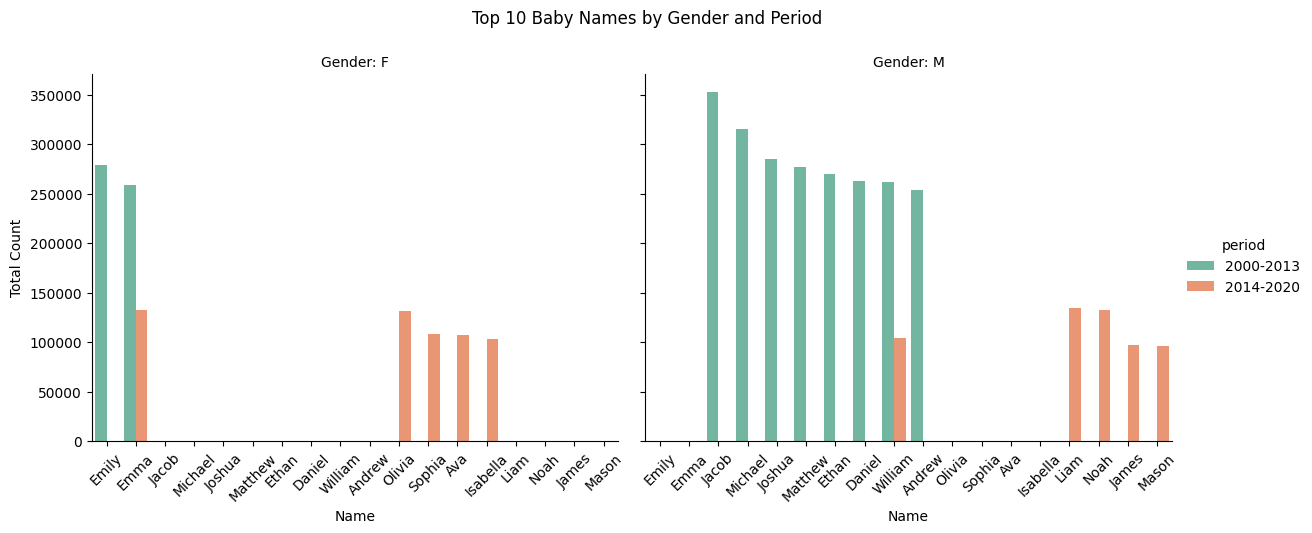

In [17]:
g = sns.catplot(
    data=top10_compare_results,
    x="name",
    y="total",
    hue="period",
    col="gender",
    kind="bar",
    height=5,
    aspect=1.2,
    palette="Set2"
)
g.set_titles("Gender: {col_name}")
g.set_axis_labels("Name", "Total Count")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Top 10 Baby Names by Gender and Period")
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


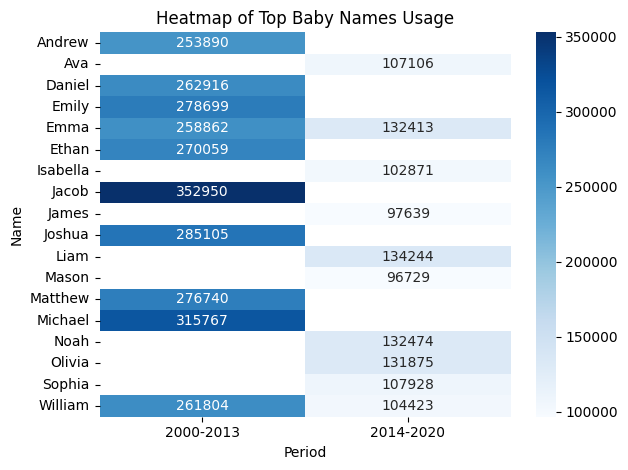

In [18]:
pivot = top10_compare_results.pivot_table(index="name", columns="period", values="total")
sns.heatmap(pivot, annot=True, fmt="g", cmap="Blues")
plt.title("Heatmap of Top Baby Names Usage")
plt.ylabel("Name")
plt.xlabel("Period")
plt.tight_layout()
plt.show()

### 📌 Distribuzione geografica dei nomi (se usi anche state dalla tabella usa_1910_current)
Esempio:
I nomi "Emma" e "Liam" sono più popolari in quali stati?
🧠 Mostra padronanza di:
GROUP BY state
PIVOT o CASE WHEN per comparazioni

In [25]:
geo_distribution_query = """ 
                      WITH ranked AS (
                      SELECT
                        name,
                        number,
                        gender,
                        state,
                        RANK() OVER (PARTITION BY state, gender ORDER BY number DESC) AS rank
                      FROM `bigquery-public-data.usa_names.usa_1910_current`
                    ),
                    top10_names AS (
                      SELECT *
                      FROM ranked
                      WHERE rank <= 10
                    )
                    SELECT *
                    FROM top10_names
                    ORDER BY state, gender, rank
                     """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
geo_distribution_job = client.query(geo_distribution_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
geo_distribution_results = geo_distribution_job.to_dataframe() # Your code goes here

# Preview results
print(geo_distribution_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


          name  number gender state  rank
0      Jessica     164      F    AK     1
1      Jessica     158      F    AK     2
2      Jessica     157      F    AK     3
3      Jessica     156      F    AK     4
4     Jennifer     155      F    AK     5
...        ...     ...    ...   ...   ...
1021      John     184      M    WY     6
1022     David     183      M    WY     7
1023   Michael     181      M    WY     8
1024    Robert     180      M    WY     9
1025      John     179      M    WY    10

[1026 rows x 5 columns]


### 1. Barplot – Nomi più popolari in uno stato selezionato

In [44]:
CA_popular_query = """ 
                      WITH ranked AS (
                      SELECT
                        name,
                        number,
                        gender,
                        state,
                        RANK() OVER (PARTITION BY state, gender ORDER BY number DESC) AS rank
                        FROM `bigquery-public-data.usa_names.usa_1910_current`
                    ), 
                    top_names AS (
                      SELECT name
                      FROM ranked
                      WHERE gender = 'F' AND rank <= 10
                      GROUP BY name
                    )
                    SELECT
                      r.state,
                      r.name,
                      SUM(r.number) AS total
                    FROM ranked r
                    JOIN top_names t ON r.name = t.name
                    WHERE r.gender = 'F' AND r.state = 'CA'
                    GROUP BY r.state, r.name
                    ORDER BY r.state, total DESC
                   """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
CA_popular_job = client.query(CA_popular_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
CA_popular_results = CA_popular_job.to_dataframe() # Your code goes here

# Preview results
print(CA_popular_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   state      name   total
0     CA  Jennifer  175321
1     CA      Mary  152978
2     CA   Jessica  135825
3     CA  Patricia  116894
4     CA     Linda  114809
5     CA    Ashley   97093
6     CA      Lisa   94651
7     CA  Isabella   56848
8     CA   Deborah   56529
9     CA     Debra   44154
10    CA     Betty   36176
11    CA   Shirley   31716


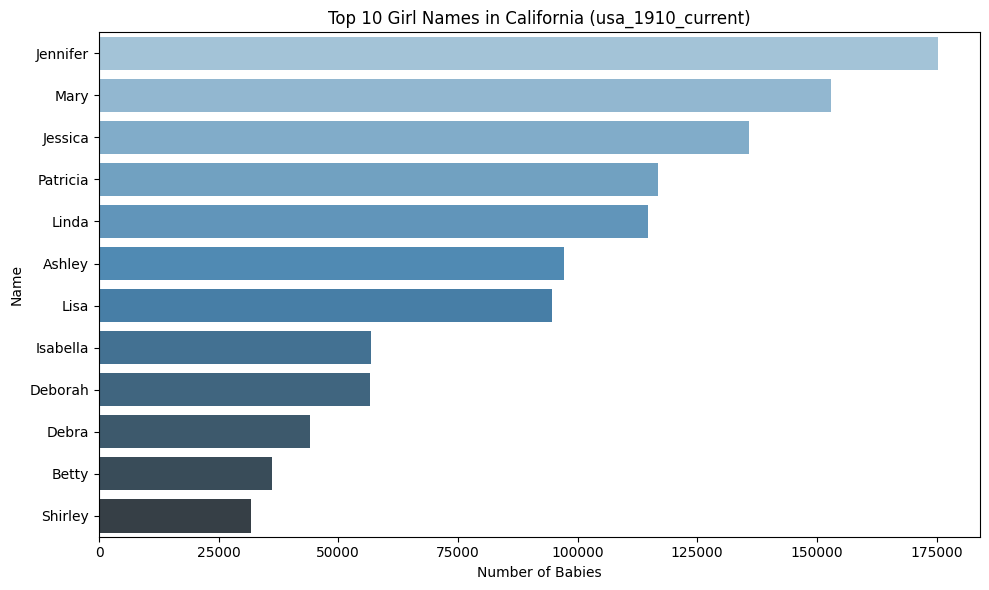

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

CA_popular_results = CA_popular_results.dropna(subset=["total"])
CA_popular_results["total"] = CA_popular_results["total"].astype(int)

# Supponiamo che i dati siano stati caricati in un DataFrame chiamato df_ca_female
plt.figure(figsize=(10, 6))
sns.barplot(data=CA_popular_results, x="total", y="name", palette="Blues_d")
plt.title("Top 10 Girl Names in California (usa_1910_current)")
plt.xlabel("Number of Babies")
plt.ylabel("Name")
plt.tight_layout()
plt.show()

### 2. Heatmap – Frequenza di nomi per stato
### Visualizziamo quanti bambini sono nati con i top 5 nomi maschili in ciascuno stato (solo per esempio).

In [41]:
CA_top5_query = """ 
                      WITH ranked AS (
                      SELECT
                        name,
                        gender,
                        state,
                        number,
                        RANK() OVER (PARTITION BY state, gender ORDER BY number DESC) AS rank
                        FROM `bigquery-public-data.usa_names.usa_1910_current`
                    ),
                    top_names AS (
                      SELECT name
                      FROM ranked
                      WHERE gender = 'M' AND rank <= 5
                      GROUP BY name
                    )
                    SELECT
                      r.state,
                      r.name,
                      SUM(r.number) AS total
                    FROM ranked r
                    JOIN top_names t ON r.name = t.name
                    WHERE r.gender = 'M'
                    GROUP BY r.state, r.name
                    ORDER BY r.state, total DESC
                     """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
CA_top5_job = client.query(CA_top5_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
CA_top5_results = CA_top5_job.to_dataframe() # Your code goes here

# Preview results
print(CA_top5_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


    state         name  total
0      AK      Michael   8302
1      AK         John   7279
2      AK        James   6976
3      AK        David   6683
4      AK       Robert   6435
..    ...          ...    ...
352    WY        James   8160
353    WY      Michael   7221
354    WY        David   6257
355    WY      Richard   4702
356    WY  Christopher   3192

[357 rows x 3 columns]


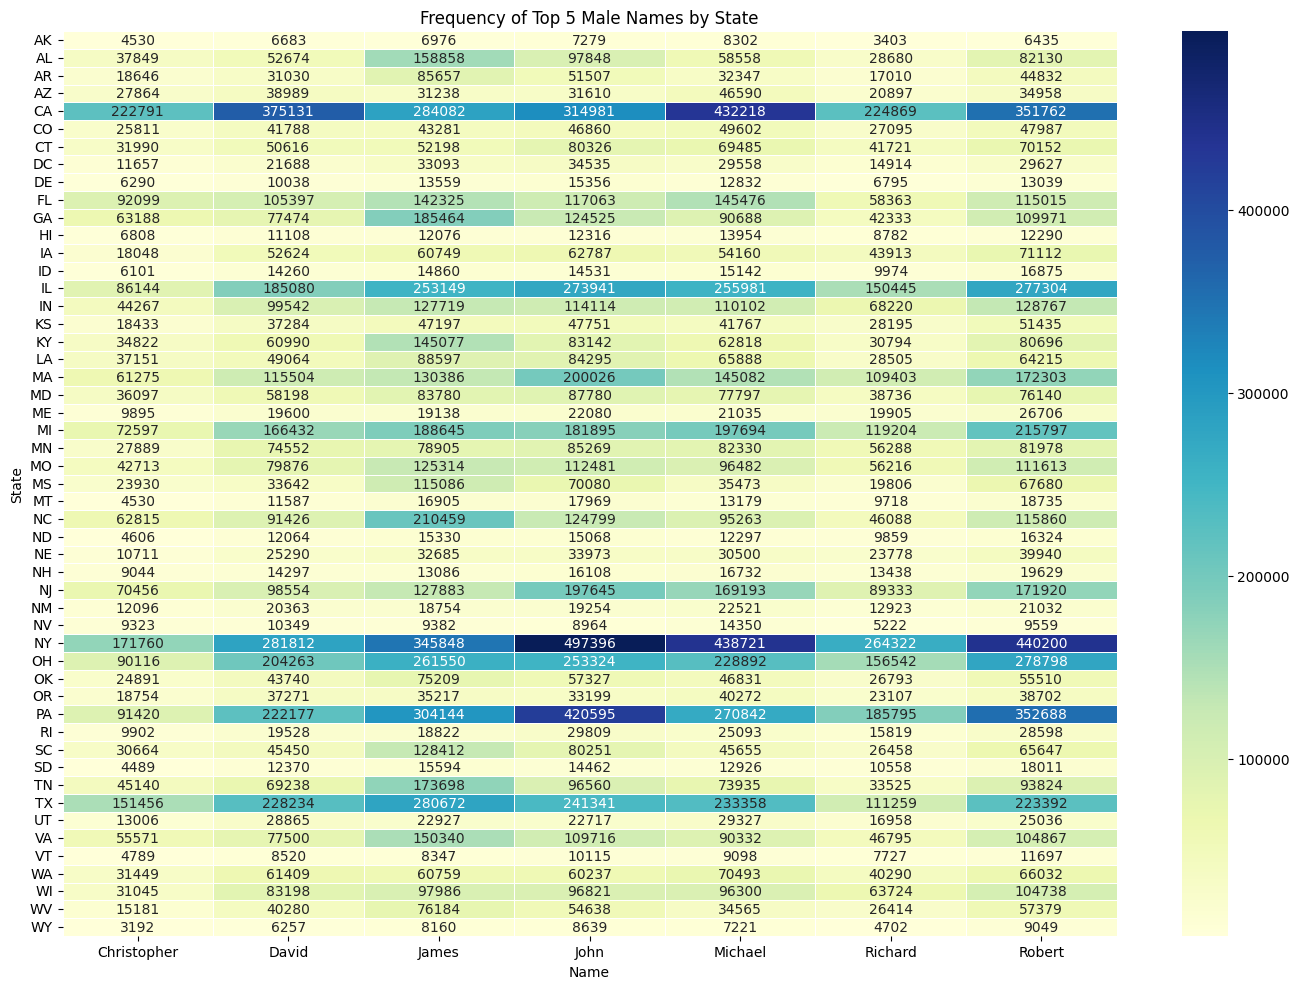

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CA_top5_results = CA_top5_results.dropna(subset=["total"])
CA_top5_results["total"] = CA_top5_results["total"].astype(int)

# Supponiamo che il DataFrame sia df_heat
df_pivot = CA_top5_results.pivot(index="state", columns="name", values="total").fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(df_pivot, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=0.5)
plt.title("Frequency of Top 5 Male Names by State")
plt.xlabel("Name")
plt.ylabel("State")
plt.tight_layout()
plt.show()


### 🎯 Obiettivo:
### Stimare quante bambine nasceranno con il nome "Olivia" nel 2026, 2027 ecc.

In [26]:
olivia_query = """   SELECT
                      year,
                      SUM(number) AS total
                    FROM `bigquery-public-data.usa_names.usa_1910_2013`
                    WHERE name = 'Olivia' AND gender = 'F'
                    GROUP BY year
                    ORDER BY year
                     """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
olivia_job = client.query(olivia_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
olivia_results = olivia_job.to_dataframe() # Your code goes here

# Preview results
print(olivia_results)

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     year  total
0    1910    176
1    1911    146
2    1912    233
3    1913    246
4    1914    295
..    ...    ...
99   2009  17416
100  2010  17004
101  2011  17286
102  2012  17253
103  2013  18256

[104 rows x 2 columns]


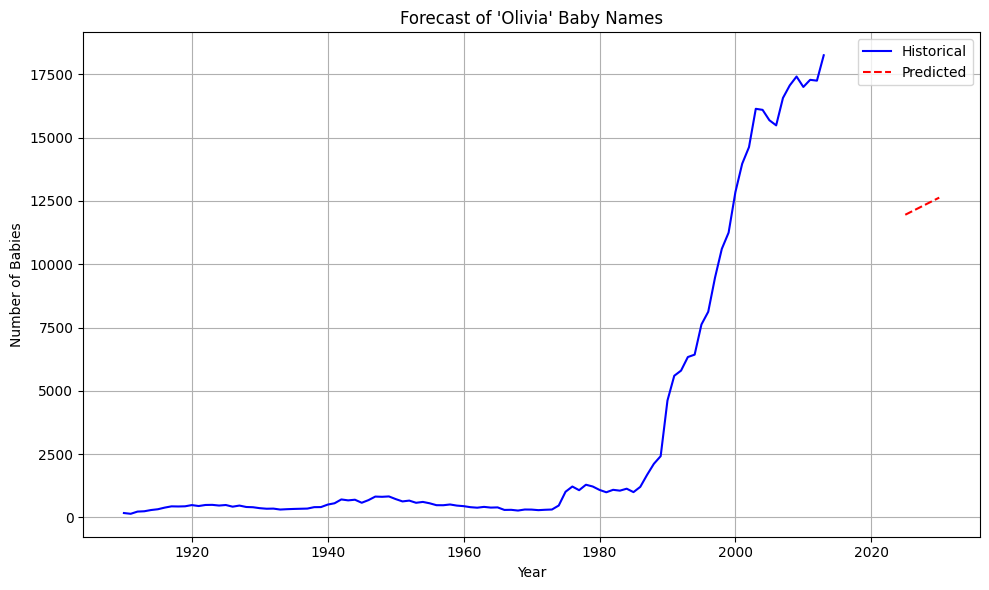

In [27]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Supponi che `df_olivia` abbia colonne: 'year', 'total'
X = olivia_results[["year"]].values
y = olivia_results["total"].values

model = LinearRegression()
model.fit(X, y)

# Previsione 2025–2030
future_years = np.arange(2025, 2031).reshape(-1, 1)
predictions = model.predict(future_years)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(olivia_results["year"], olivia_results["total"], label="Historical", color="blue")
plt.plot(future_years, predictions, label="Predicted", color="red", linestyle="--")
plt.title("Forecast of 'Olivia' Baby Names")
plt.xlabel("Year")
plt.ylabel("Number of Babies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
